In [1]:
'''
from google.colab import drive

drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\n\ndrive.mount('/content/drive')\n"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#%cd "/content/drive/MyDrive/Inteligencia Artificial"
data = pd.read_csv("dataus2024.csv")
data.shape

(557181, 24)

In [3]:
firms = pd.read_csv('firmsus2024.csv')
firms.shape

(5689, 7)

In [4]:
print(type(data.head()))

<class 'pandas.core.frame.DataFrame'>


In [5]:
# Concat de data con firms para jalar columnas de industria, nombre empresa en data
firms1 = firms[["empresa", "Nombre", "status", "naics1"]]
firms1.columns = ["firm", "Empresa", "status", "industria"]

data = pd.merge(data, firms1, on="firm", how="left")
data.head()

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,originalprice,sharesoutstanding,year,fixedassets,yearf,cto,fiscalq,Empresa,status,industria
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104.0000,452000.000,2000,NaN,NaN,1,NaN,"Agilent Technologies, Inc",activo,Industrias manufactureras
1,A,2000q2,6.0,4731000.0,2421000.0,1925000.0,73000.0,0.0,0.0,161000.0,...,73.7500,452271.967,2000,1453000.0,2000.0,2,2.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
2,A,2000q3,9.0,7401000.0,3790000.0,3016000.0,101000.0,0.0,0.0,244000.0,...,48.9375,453014.579,2000,1581000.0,2000.0,3,3.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
3,A,2000q4,12.0,10773000.0,5522000.0,4198000.0,111000.0,0.0,0.0,407000.0,...,54.7500,456366.381,2000,1741000.0,2000.0,4,4.0,"Agilent Technologies, Inc",activo,Industrias manufactureras
4,A,2001q1,3.0,2841000.0,1449000.0,1113000.0,19000.0,-25000.0,0.0,119000.0,...,30.7300,456769.737,2001,1821000.0,2001.0,1,1.0,"Agilent Technologies, Inc",activo,Industrias manufactureras


Calculo la variable columna de NetIncome y otras asociadas:

**Utilidad bruta = Gross Profit =** $Revenue - COGS$

**COGS = Cost of Good Sold; son los gastos VARIABLES; cambian con las ventas**

**Utilidad operativa antes de impuesto = Earnings before Onterests and Taxes**

**EBIT (Utilidad Operativa Antes de Impuestos) =** $Gross profit - SGAE$

*SGAE = Safe and General Administrative Expenses

**Net Income =** $EBIT - FINEXP - INCOMETAX + OTHERINCOME + EXTRAORDINARYITEMS$

*FINEXP = Pago de Intereses de Préstamos

*INCOMETAX = Pago de Impuesto Sobre la Renta

*OTHERINCOME = Otras ventas que no sean del core del negocio

*EXTRAORDINARYITEMS = Ventas extraordinarias

*ETB = Utilidad antes de impuesto

*NETINCOME = Utilidad neta, es decir, todas las ganancias menos los gastos

In [6]:
data["GROSSPROFIT"] = data["revenue"] - data["cogs"]
data["EBIT"] = data["GROSSPROFIT"] - data["sgae"]
data["NETINCOME"] = data["EBIT"] - data["finexp"] - data["incometax"] + data["otherincome"] + data["extraordinaryitems"]
data["EBT"] = data['EBIT'] - data["finexp"] + data["otherincome"] + data["extraordinaryitems"]
data['Effective_Tax_Rate'] = data['incometax'] / data['EBT']
data['NOPAT'] = data['EBIT'] * (1 - data['Effective_Tax_Rate'])

Cálculo de Valor de Mercado y Valor en Libros

Valor de Mercado = MARKET VALUE = $originalprice * sharesoutstanding$
originalprice = precio original de la acción
sharepitstanding = Número de acciones disponibles


Valor en Libros = BOOKVALUE = $totalassets - totalliabilities$

totalassets = total de activos (recursos)

totalliabilities = total de pasivos

In [7]:
data['BOOKVALUE'] = data['totalassets'] - data['totalliabilities']
data['MARKETVALUE'] = data['originalprice'] * data['sharesoutstanding']
data['BOOKMARKET'] = data['BOOKVALUE'] / data['MARKETVALUE']

El BOOK-TO-MARKET es una variable de "Control" que vamos a incluir en el modelo de regresión.

En estadística se le llama variable de control a aquellas variables independientes (explicativas) que en la disciplina de estudio se ha encontrado que tiene mucha correlación con la variable dependiente.

Generamos la $variable / ratio$ de earning per share, que será otra variable de control

**¿Qué es earning per share deflated by price?**

**¿Qué es Earnings?**

Earning se puede medir con alguna variable de utilidad.
Ejemplo:
- NETINCOME
- EBIT (Utilidad Operativa)

**EARNING PER SHARE = EPS =** $EARNINGS / shareoutstanding$

**EARNING PER SHARE DEFLATED BY PRICE = EPSP =** $EPS / originalprice$

In [8]:
data['EPS'] = data['NETINCOME'] / data['sharesoutstanding']
data['EPSP'] = data['EPS'] / data['originalprice']

Ahora calculamos los retornos de acción para todas las empresas (trimestrales y anuales)

**Retorno trimestral = QR =** adjprice / adjprice{t-1} -1

**Retorno anual = YR =** adjprice / adjprice{t-4} - 1

Retornos Continuos Compuestos:

ret trimestral = qr = log(adjprice) - log(adjprice{t-1}) = log(adjprice / adjprice{t-1})

ret anual = yr = log(adjprice) - log(adjprice{t-4})


Genero un úndice en el dataset por firm-quarter:

In [9]:
data['qdate'] = pd.PeriodIndex(data.q, freq = 'Q')
data.set_index(['firm', 'qdate'], inplace = True)
data.head()
data.index

MultiIndex([(     'A', '2000Q1'),
            (     'A', '2000Q2'),
            (     'A', '2000Q3'),
            (     'A', '2000Q4'),
            (     'A', '2001Q1'),
            (     'A', '2001Q2'),
            (     'A', '2001Q3'),
            (     'A', '2001Q4'),
            (     'A', '2002Q1'),
            (     'A', '2002Q2'),
            ...
            ('ZY_old', '2022Q1'),
            ('ZY_old', '2022Q2'),
            ('ZY_old', '2022Q3'),
            ('ZY_old', '2022Q4'),
            ('ZY_old', '2023Q1'),
            ('ZY_old', '2023Q2'),
            ('ZY_old', '2023Q3'),
            ('ZY_old', '2023Q4'),
            ('ZY_old', '2024Q1'),
            ('ZY_old', '2024Q2')],
           names=['firm', 'qdate'], length=557181)

Calcular los CC Returns para cada trimestre y anual de cada firma.

In [10]:
# Quarter returns
data['return_q'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(1))
# Yearly returns
data['return_y'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(4))
print(data.head())

                  q  fiscalmonth     revenue       cogs       sgae  \
firm qdate                                                           
A    2000Q1  2000q1          NaN         NaN        NaN        NaN   
     2000Q2  2000q2          6.0   4731000.0  2421000.0  1925000.0   
     2000Q3  2000q3          9.0   7401000.0  3790000.0  3016000.0   
     2000Q4  2000q4         12.0  10773000.0  5522000.0  4198000.0   
     2001Q1  2001q1          3.0   2841000.0  1449000.0  1113000.0   

             otherincome  extraordinaryitems  finexp  incometax  totalassets  \
firm qdate                                                                     
A    2000Q1          NaN                 NaN     NaN        NaN          NaN   
     2000Q2      73000.0                 0.0     0.0   161000.0    7321000.0   
     2000Q3     101000.0                 0.0     0.0   244000.0    7827000.0   
     2000Q4     111000.0                 0.0     0.0   407000.0    8425000.0   
     2001Q1      19000.0     

Calcule los rendimientos CC returns futuros (un cuarto por delante)

In [11]:
data['return_q_future'] = data.groupby(['firm'])['return_q'].shift(-1)
#data['return_q_future'] = data.groupby(['firm'])['return_q'].shift(-4)

#data['return_y_future'] = data.groupby(['firm'])['return_y'].shift(-1)
data['return_y_future'] = data.groupby(['firm'])['return_y'].shift(-4)

print(data.head())

                  q  fiscalmonth     revenue       cogs       sgae  \
firm qdate                                                           
A    2000Q1  2000q1          NaN         NaN        NaN        NaN   
     2000Q2  2000q2          6.0   4731000.0  2421000.0  1925000.0   
     2000Q3  2000q3          9.0   7401000.0  3790000.0  3016000.0   
     2000Q4  2000q4         12.0  10773000.0  5522000.0  4198000.0   
     2001Q1  2001q1          3.0   2841000.0  1449000.0  1113000.0   

             otherincome  extraordinaryitems  finexp  incometax  totalassets  \
firm qdate                                                                     
A    2000Q1          NaN                 NaN     NaN        NaN          NaN   
     2000Q2      73000.0                 0.0     0.0   161000.0    7321000.0   
     2000Q3     101000.0                 0.0     0.0   244000.0    7827000.0   
     2000Q4     111000.0                 0.0     0.0   407000.0    8425000.0   
     2001Q1      19000.0     

Calcular al menos 4 financial ratios para cada variable independiente que será usada para predecir el futuro stock return

**ROE (Return On Equity):** Ganancias netas / Inversión de capital de accionistas.

Mide rentabilidad y ediciencia de la empresa al momento de generar rendimientos para la inversión de capital de accionistas (eficacia del dinero de los accionistas una empresa para generar ganancias). Mayor ROE = Uso eficiente del capital.

In [12]:
# Return on Equity (ROE)
data['ROE'] = data['NETINCOME'] / data['BOOKVALUE']

**NPM (Net Profit Margin):** Ganancias netas / Ingresos

Mide el porcentaje de ganancias que produce una compañia en comparación con sus ingresos. Tiene un enfoque en la rentabilidad de la empresa.

In [13]:
# Net Profit Margin
data['NPM'] = data['NETINCOME'] / data['revenue']

**ROIC (Return on Invested Capital):** Utilidad operativa neta después de impuestos / Capital invertido

Mide la eficiencia con la que una empresa usa su capital para generar utilidad. Un ROIC alto indica que la empresa está obteniendo un alto rendimiento por cada unidad unidad de capital invertido.

In [14]:
# Return on Invested Capital (ROIC)
data['ROIC'] = data['NOPAT'] / data['totalassets']

**OPM (Operating Profit Margin):** EBIT / Revenue

Mide el porcentaje de los ingresos que se convierte en utilidades operativas (excluyendo intereses, impuestos, etc). A mayor margen operativo, una empresa es más eficiente de convertir ventas en utilidades (gran capacidad de generar ganancias con las operaciones básicas).

In [15]:
# Operating Profit Margin
data['OPM'] = data['EBIT'] / data['revenue']

### 1.2 Composición firme del mercado financiero estadounidense

1. Empresas activas por industria hay en la muestra

In [16]:
active_firms = data[data['status'] == 'activo'].groupby('industria')['Empresa'].nunique()
print(active_firms)

industria
-                                                                                                   2
Agricultura, ganadería, aprovechamiento forestal, pesca y caza                                     17
Comercio al por mayor                                                                              74
Comercio al por menor                                                                             141
Construcción                                                                                       47
Empresas de electricidad, gas y agua                                                               78
Industrias manufactureras                                                                        1499
Información en medios masivos                                                                     243
Minería, explotación de canteras y extracción de petróleo y gas                                   109
Otros servicios excepto actividades gubernamentales                     

In [17]:
total_active_firms = active_firms.sum()
print('Total de empresas activas en todas las industrias:', total_active_firms)

Total de empresas activas en todas las industrias: 3444


2. Tabla de estadísticas sobre el book value y el market value por industria.

In [18]:
# Calcular las estadísticas para 'BOOKVALUE' y 'MARKETVALUE' por industria
bookvalue_stats = data.groupby('industria')['BOOKVALUE'].describe()
marketvalue_stats = data.groupby('industria')['MARKETVALUE'].describe()

# Convertir el resultado de describe a un dataframe. Asignar títulos a las columnas
bookvalue_df = bookvalue_stats.apply(pd.Series).rename(columns=lambda x: f'BOOKVALUE: {x}')
marketvalue_df = marketvalue_stats.apply(pd.Series).rename(columns=lambda x: f'MARKETVALUE: {x}')

# Concatenar los dos df de manera horizontal
statistics = pd.concat([bookvalue_df, marketvalue_df], axis=1)

# Poner a "industria" como columna, no como índice
statistics.reset_index(inplace=True)

print(statistics)


                                            industria  BOOKVALUE: count  \
0                                                   -              31.0   
1   Agricultura, ganadería, aprovechamiento forest...            1019.0   
2                               Comercio al por mayor            6001.0   
3                               Comercio al por menor           12851.0   
4                                        Construcción            3431.0   
5                                        Corporativos              67.0   
6                Empresas de electricidad, gas y agua            8100.0   
7                           Industrias manufactureras           98278.0   
8                       Información en medios masivos           18365.0   
9   Minería, explotación de canteras y extracción ...           10794.0   
10  Otros servicios excepto actividades gubernamen...            1061.0   
11  Servicios de alojamiento temporal y de prepara...            4673.0   
12  Servicios de apoyo a 

**¿Qué se puede decir sobre el tamaño típico de una empresa en términos de valor de mercado y valor contable?**

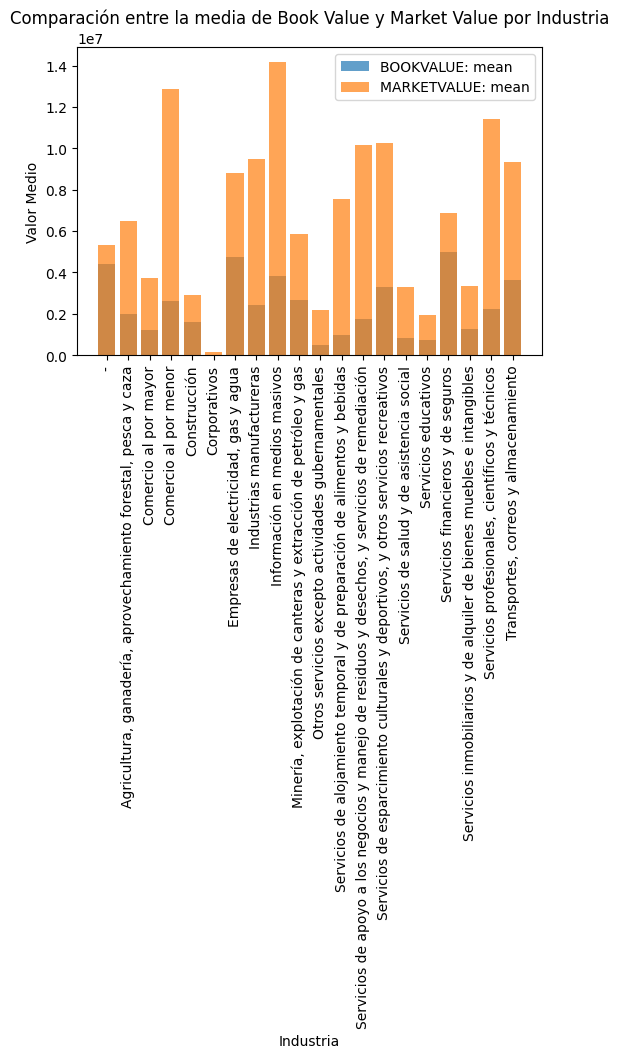

In [19]:
# Calcular la media de BOOKVALUE y MARKETVALUE por industria
bookvalue_mean = data.groupby('industria')['BOOKVALUE'].mean().reset_index()
marketvalue_mean = data.groupby('industria')['MARKETVALUE'].mean().reset_index()
bookvalue_mean = bookvalue_mean.rename(columns={'BOOKVALUE': 'BOOKVALUE_mean'})
marketvalue_mean = marketvalue_mean.rename(columns={'MARKETVALUE': 'MARKETVALUE_mean'})

# Unir ambas medias en un df para graficar
statistics = pd.merge(bookvalue_mean, marketvalue_mean, on='industria')

# Crear la gráfica comparativa
plt.figure(figsize=(6, 4))
plt.bar(statistics['industria'], statistics['BOOKVALUE_mean'], label='BOOKVALUE: mean', alpha=0.7)
plt.bar(statistics['industria'], statistics['MARKETVALUE_mean'], label='MARKETVALUE: mean', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Valor Medio')
plt.title('Comparación entre la media de Book Value y Market Value por Industria')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

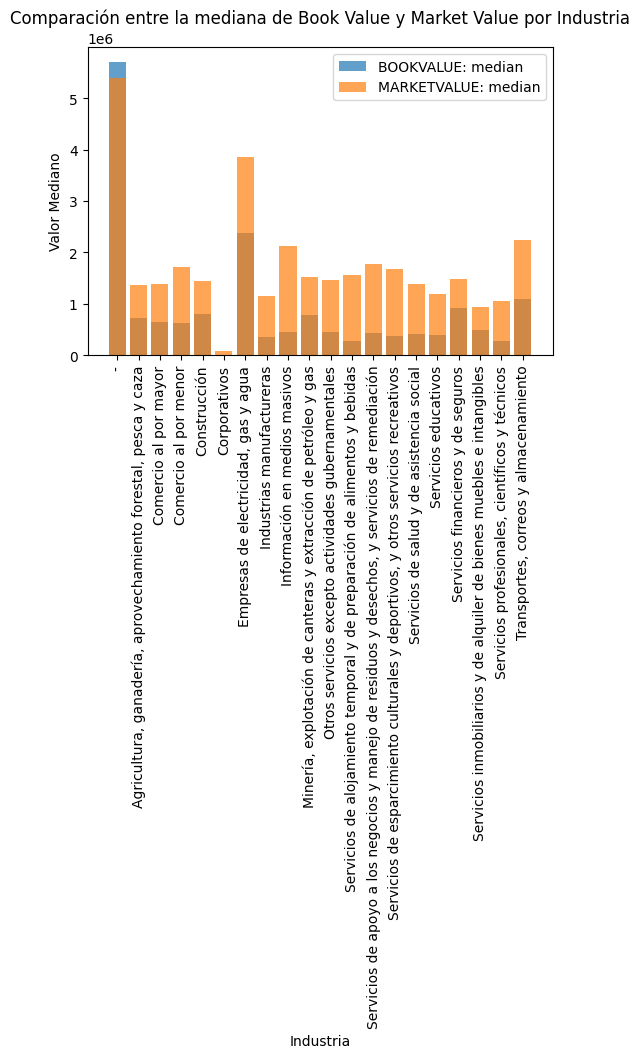

In [20]:
# Calcular la mediana de BOOKVALUE y MARKETVALUE por industria
bookvalue_median = data.groupby('industria')['BOOKVALUE'].median().reset_index()
marketvalue_median = data.groupby('industria')['MARKETVALUE'].median().reset_index()

# Renombrar las columnas para diferenciarlas
bookvalue_median = bookvalue_median.rename(columns={'BOOKVALUE': 'BOOKVALUE_median'})
marketvalue_median = marketvalue_median.rename(columns={'MARKETVALUE': 'MARKETVALUE_median'})

# Unir ambas medianas en un df para graficar
stats_mediana = pd.merge(bookvalue_median, marketvalue_median, on='industria')

# Crear la gráfica comparativa
plt.figure(figsize=(6, 4))
plt.bar(stats_mediana['industria'], stats_mediana['BOOKVALUE_median'], label='BOOKVALUE: median', alpha=0.7)
plt.bar(stats_mediana['industria'], stats_mediana['MARKETVALUE_median'], label='MARKETVALUE: median', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Valor Mediano')
plt.title('Comparación entre la mediana de Book Value y Market Value por Industria')
plt.xticks(rotation=90)
plt.legend()
plt.show()


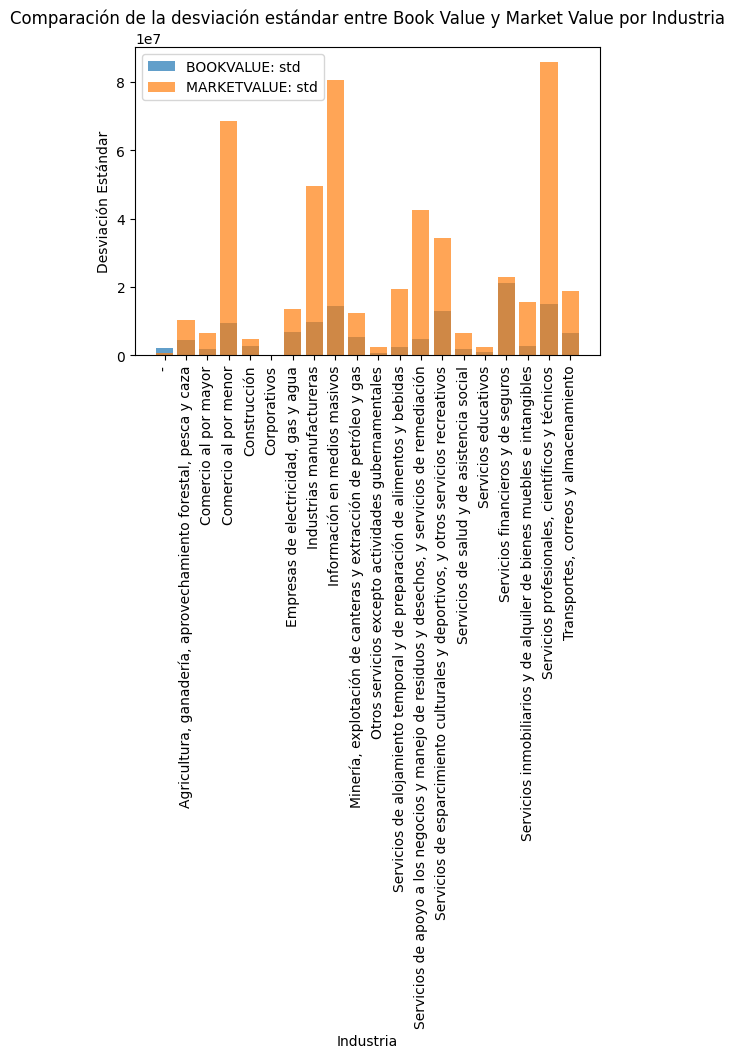

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcular la desviación estándar de BOOKVALUE y MARKETVALUE por industria
bookvalue_std = data.groupby('industria')['BOOKVALUE'].std().reset_index()
marketvalue_std = data.groupby('industria')['MARKETVALUE'].std().reset_index()

# Renombrar las columnas para diferenciarlas
bookvalue_std = bookvalue_std.rename(columns={'BOOKVALUE': 'BOOKVALUE_std'})
marketvalue_std = marketvalue_std.rename(columns={'MARKETVALUE': 'MARKETVALUE_std'})

# Unir ambas desviaciones estándar en un df para graficar
statistics_std = pd.merge(bookvalue_std, marketvalue_std, on='industria')

# Crear la gráfica comparativa
plt.figure(figsize=(6, 4))
plt.bar(statistics_std['industria'], statistics_std['BOOKVALUE_std'], label='BOOKVALUE: std', alpha=0.7)
plt.bar(statistics_std['industria'], statistics_std['MARKETVALUE_std'], label='MARKETVALUE: std', alpha=0.7)
plt.xlabel('Industria')
plt.ylabel('Desviación Estándar')
plt.title('Comparación de la desviación estándar entre Book Value y Market Value por Industria')
plt.xticks(rotation=90)
plt.legend()
plt.show()


En casi todas las industrias, el Market Value mediano es significativamente mayor a la mediana del Book Value, lo cual, puede significar que el mercado suelen valorar a las empresas por encima de su Book Value (sobrevaloran empresas). Además, notamos que la media, tanto en Book Value como en Market Value, tiende a ser más alta (esto puede ser debido a que existan empresas grandes que cuesten mucho y que se cotizen, causando un desbalance en la dispersión de los datos), por ello, la mediana podría ser una representación más fiel para representar a la mayoría de las empresas porque no se deja influenciar por los outliers.

El tamaño típico de una empresa en términos de market Value muestra una alta variabilidad dentro de muchas industrias, lo que sugiere que unas empresas son mucho más grandes que otras en términos de Market Value.

En términos de Book Value, las empresas suelen ser más similares entre ellas con menos variabilidad, por lo que puede ser representativo para mostrar a la mayoría de las empresas.

**¿Cuánto cambian estas variables dentro de cada industria? :**


El Market Value, en muchas de las industrias presenta gran variabilidad (que se nota en las altas variaciones estándar de la gráfica), lo que sugiere que dentro de la misma industria, los Market Values de las empresas pueden cambiar considerablemente (unas empresas pueden tener un MV muy alto mientras que otras muy bajo). Esto puede distorsionar el promedio (por lo anteriormente comentado), es por eso que la mediana sería un valor más fiel para representar a la mayoría de las empresas.

El Book Value por otro lado, muestra menos variabilidad entre industrias, por lo que existe una desviación estándar mucho menor (en comparación con MV), indicando que las empresas tienen BV más cercanos entre sí. Por ello, la mediana es la mejor representación para representar a la mayoría de las empresas de igual manera.



**¿Cómo se distribuye el tamaño de la empresa (en valor de mercado)?**

La distribución del tamaño de la empresa (en razón del Market value) muestra una gran variabilidad dentro de muchas de las industrias, pues existe una gran discrepancia entre su media, mediana y una desviación estándar alta. Podemos ver que existe un sesgo a la derecha, lo que indica que no hay tantas empresas con un tamaño considerablemente mayor a las otras, es por eso que la mediana es una mejor medida para representar a la mayoría de las empresas en lugar de la media, ya que la media se encuentra sesgada por los outliers.

3. ¿Cuáles son las 10 empresas estadounidenses más grandes en términos de valor de mercado y qué tan lejos están del tamaño de mercado típico de una empresa estadounidense?

In [22]:
# Ordenar las empresas por valor de mercado en orden descendente y agrupándolas por empresa (para que no se repitan empresas)
first_10_companies = data.groupby('Empresa')['MARKETVALUE'].sum().sort_values(ascending=False).head(10)

# Tomar los nombres de las primeras 10 empresas
first_10_names = first_10_companies.index

# Filtrar las primeras 10 empresas
first_10_data = data[data['Empresa'].isin(first_10_names)]

# Hacer una tabla con los nombres de las 10 empresas, su industria y su suma de Market value
result = first_10_data.groupby('Empresa').agg({'industria': 'first', 'MARKETVALUE': 'sum'}).sort_values('MARKETVALUE', ascending=False)

# Imprimir las empresas
print(result)


                                                                industria  \
Empresa                                                                     
Apple Inc                                       Industrias manufactureras   
Microsoft Corp                              Información en medios masivos   
Alphabet Inc              Servicios profesionales, científicos y técnicos   
Amazon.Com, Inc                                     Comercio al por menor   
Exxon Mobil Corp                                Industrias manufactureras   
Walmart Inc                                         Comercio al por menor   
Johnson & Johnson                               Industrias manufactureras   
General Electric Company                        Industrias manufactureras   
Meta Platforms, Inc       Servicios profesionales, científicos y técnicos   
Jpmorgan Chase & Co                    Servicios financieros y de seguros   

                           MARKETVALUE  
Empresa                           

In [23]:
# Sumar todos los Market Values de todas las empresas
company_market_values = data.groupby('Empresa')['MARKETVALUE'].sum()
# Calcular el tamaño típico del mercado (con la mediana y no la media porque la media posee muchos outliers, es decir, desviación estándar)
median_market_value = company_market_values.median()
print('Tamaño típico del mercado:', median_market_value)

Tamaño típico del mercado: 34997992.625555396


In [24]:
# Distancia entre el tamaño de mercado típico y el Market Value del top 10 empresas
first_10_companies['distance_from_median'] = first_10_companies - median_market_value
print(first_10_companies['distance_from_median'])

Empresa
Apple Inc                   6.968498e+10
Microsoft Corp              6.807201e+10
Alphabet Inc                4.734901e+10
Amazon.Com, Inc             4.007766e+10
Exxon Mobil Corp            3.377943e+10
Walmart Inc                 2.542652e+10
Johnson & Johnson           2.501088e+10
General Electric Company    2.361824e+10
Meta Platforms, Inc         2.306267e+10
Jpmorgan Chase & Co         2.154043e+10
Name: MARKETVALUE, dtype: float64


In [25]:
# Calcular el porcentaje de diferencia
first_10_companies['percentage_difference'] = ((first_10_companies - median_market_value) / median_market_value) * 100
print(first_10_companies['percentage_difference'])

Empresa
Apple Inc                                                       199111.374359
Microsoft Corp                                                  194502.604479
Alphabet Inc                                                    135290.642586
Amazon.Com, Inc                                                 114514.153784
Exxon Mobil Corp                                                 96518.199263
Walmart Inc                                                      72651.381056
Johnson & Johnson                                                71463.754471
General Electric Company                                         67484.553937
Meta Platforms, Inc                                              65897.114743
Jpmorgan Chase & Co                                              61547.619194
distance_from_median        Empresa
Apple Inc                   199011.374...
Name: MARKETVALUE, dtype: object


Las empresas con un mayor Market Value están alejadas de un 61547% hasta un 199111% del tamaño típico de una empresa en US (lo cual, es demasiado), por lo que podemos intuir que estas son las empresas que forman parte de los outliers de la distribución de MARKETVALUE.

4. ¿Cuáles son las 10 empresas estadounidenses más grandes en términos de valor contable y qué tan lejos están del tamaño contable típico de una empresa estadounidense?

In [26]:
# Ordenar las empresas por Book value en orden descendente y agrupándolas por empresa (para que no sea repitan empresas)
first_10_book = data.groupby('Empresa')['BOOKVALUE'].sum().sort_values(ascending=False).head(10)

# Tomar los nombres de las primeras 10 empresas
first_10_names_book = first_10_book.index

# Filtrar las primeras 10 empresas
first_10_data_book = data[data['Empresa'].isin(first_10_names_book)]

# Hacer una tabla con los nombres de las 10 empresas, su industria y su suma de book value
result_book = first_10_data_book.groupby('Empresa').agg({'industria': 'first', 'BOOKVALUE': 'sum'}).sort_values('BOOKVALUE', ascending=False)

# Imprimir las empresas
print(result_book)

                                                                industria  \
Empresa                                                                     
Berkshire Hathaway Inc                 Servicios financieros y de seguros   
Bank Of America Corp                   Servicios financieros y de seguros   
Jpmorgan Chase & Co                    Servicios financieros y de seguros   
Citigroup Inc                          Servicios financieros y de seguros   
Exxon Mobil Corp                                Industrias manufactureras   
Wells Fargo & Company                  Servicios financieros y de seguros   
Chevron Corp                                    Industrias manufactureras   
AT&T Inc                                    Información en medios masivos   
Alphabet Inc              Servicios profesionales, científicos y técnicos   
General Electric Company                        Industrias manufactureras   

                             BOOKVALUE  
Empresa                           

In [27]:
# Sumar todos los Book Values de todas las empresas
company_book_values = data.groupby('Empresa')['BOOKVALUE'].sum()
# Calcular el tamaño típico del mercado (con la mediana y no la media porque la media posee muchos outliers, es decir, desviación estándar)
median_book_value = company_book_values.median()
print('Tamaño típico del mercado:', median_book_value)

Tamaño típico del mercado: 11830299.0


In [28]:
# Distancia entre el tamaño de mercado típico y el Book Value del top 10 empresas
first_10_book['distance_from_median'] = first_10_book - median_book_value
print(first_10_book['distance_from_median'])

Empresa
Berkshire Hathaway Inc      2.166258e+10
Bank Of America Corp        1.915877e+10
Jpmorgan Chase & Co         1.785957e+10
Citigroup Inc               1.578566e+10
Exxon Mobil Corp            1.416238e+10
Wells Fargo & Company       1.211942e+10
Chevron Corp                1.025700e+10
AT&T Inc                    1.009984e+10
Alphabet Inc                9.293003e+09
General Electric Company    8.575766e+09
Name: BOOKVALUE, dtype: float64


In [29]:
# Calcular el porcentaje de diferencia
first_10_book['percentage_difference'] = ((first_10_book - median_book_value) / median_book_value) * 100
print(first_10_book['percentage_difference'])


Empresa
Berkshire Hathaway Inc                                          183110.999147
Bank Of America Corp                                            161946.648187
Jpmorgan Chase & Co                                             150964.677233
Citigroup Inc                                                   133434.190471
Exxon Mobil Corp                                                119712.753676
Wells Fargo & Company                                           102443.883295
Chevron Corp                                                     86701.069018
AT&T Inc                                                         85372.624149
Alphabet Inc                                                     78552.562163
General Electric Company                                         72489.847476
distance_from_median        Empresa
Berkshire Hathaway Inc      183010.999...
Name: BOOKVALUE, dtype: object


Las empresas con un mayor Book Value están alejadas de un 72489% hasta un 183110% del tamaño típico de una empresa en US, lo cual, volvemos a intuir que estos datos tan altos se deben a que son empresas partes de los outliers de la distribución de Book Value.

### 1.3 Evolución del mercado financiero de US
Considerando el historial completo de datos financieros de todas las empresas, y solo la información fiscal anual (seleccionando mes fiscal = 12):

1. ¿Cómo ha cambiado el valor total del mercado estadounidense a lo largo de los años? Haz una tabla y/o gráfica y explica:



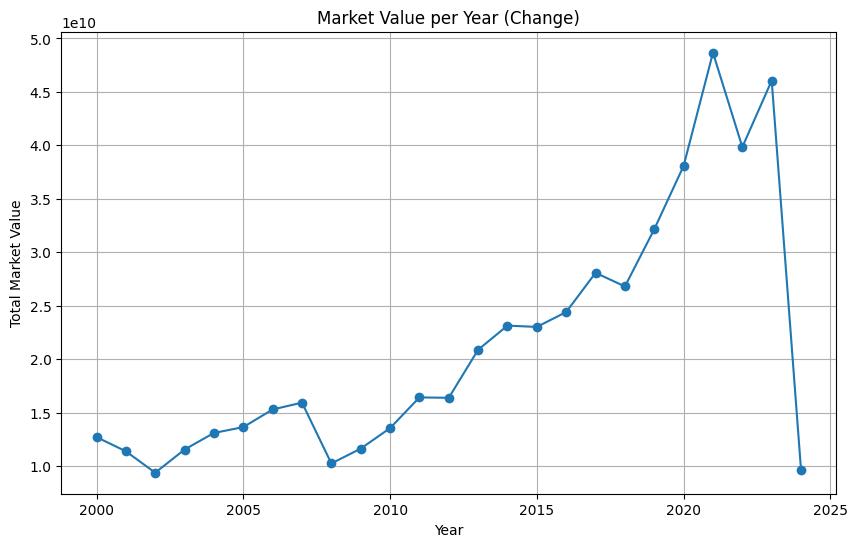

In [30]:
# Filtrar la información por año fiscal (cuando el mes sea 12)
data_per_year = data[data['fiscalmonth'] == 12]

# Calcular el MARKETVALUE total para cada año
total_market_value_per_year = data_per_year.groupby('year')['MARKETVALUE'].sum()

# Tabla por año de MKT Value
mkt_val_by_year = total_market_value_per_year.reset_index()
mkt_val_by_year.columns = ['Year', 'Market Value']

plt.figure(figsize=(10, 6))
plt.plot(mkt_val_by_year['Year'], mkt_val_by_year['Market Value'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Market Value')
plt.title('Market Value per Year (Change)')
plt.grid(True)
plt.show()


El valor total del mercado de US, de acuerdo a la gráfica, presenta una tendencia a la alta, es decir, ascendente. Ha ido escalando de manera periódica, sin embargo, existe una caída en el año 2024 aproximadamente, esto puede ser debido a que aún no ha terminado el año, por lo cual, este puede incrementar. A lo largo de los años, se presentaron fluctuaciones de 0.5  (2008) hasta de casi 1 (2022). El punto más alto del valor total del mercado fue en el 2020, y el más bajo en el 2002.

2. ¿Cómo han cambiado a lo largo de los años los ingresos totales y los ingresos netos totales de todas las empresas estadounidenses? Haz una tabla y/o gráfica y explica

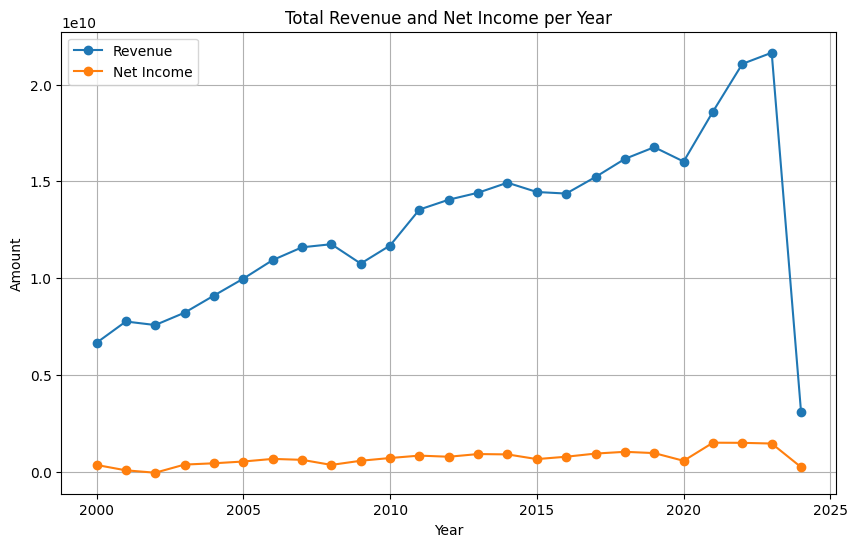

In [31]:
# Calculas los ingresos totales por año
total_revenue_per_year = data_per_year.groupby('year').agg({'revenue': 'sum', 'NETINCOME': 'sum'}).reset_index()
total_revenue_per_year.columns = ['Year', 'Revenue', 'Net Income']

# Graficar datos
plt.figure(figsize=(10, 6))
plt.plot(total_revenue_per_year['Year'], total_revenue_per_year['Revenue'], marker='o', linestyle='-', label='Revenue')
plt.plot(total_revenue_per_year['Year'], total_revenue_per_year['Net Income'], marker='o', linestyle='-', label='Net Income')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Total Revenue and Net Income per Year')
plt.legend()
plt.grid(True)
plt.show()


La línea azul (representando el total de ganancias) muestra una tendencia de crecimiento bastante constante y periódico, con pequeños picos de incremento de 0.3 aprox. Su valor más alto registrado ha sido en el 2023 y el menor en el 2000, lo cual, corresponde a que ha ido en ascenso con el paso de los años. Por otro lado, la línea naranja (que representa las ganancias netas) no ha mostrado un crecimiento significativo, pues ha fluctuado dentro de valores bastantes bajos (de 0 a 0.1), no presenta picos o decrementos significativos y suele ser el mismo valor durante todos los años.

Esto puede indicar que, las empresas han tenido un crecimiento significativo durante los años en US, sin embargo, los ingresos netos de estos han permanecido "constantes" a pesar del incremento en los ingresos, por lo que se puede intuir que el crecimiento de las empresas ha estado limitado por factores que pudieran ser como la inflación e impuestos, es por eso que puede que no tengan mucha ganancia neta a pesar de sus ganancias brutas.

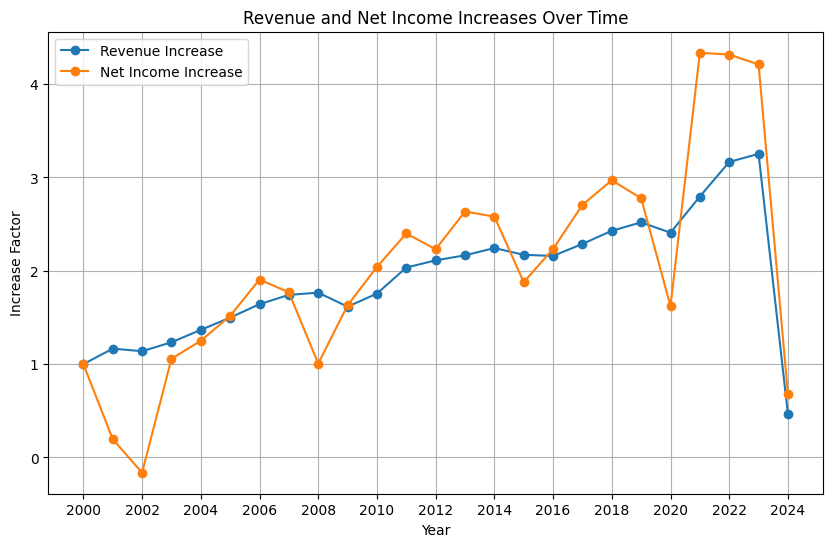

In [32]:
# Calcular el factor de incremento dividiendo cada valor por el primer valor de cada columna
mkt_val_by_year['Market Value Increase'] = mkt_val_by_year['Market Value'] / mkt_val_by_year.iloc[0]['Market Value']
total_revenue_per_year['Revenue Increase'] = total_revenue_per_year['Revenue'] / total_revenue_per_year.iloc[0]['Revenue']
total_revenue_per_year['Net Income Increase'] = total_revenue_per_year['Net Income'] / total_revenue_per_year.iloc[0]['Net Income']

# Graficar los factores de incremento
plt.figure(figsize=(10, 6))
plt.plot(total_revenue_per_year['Year'], total_revenue_per_year['Revenue Increase'], marker='o', linestyle='-', label='Revenue Increase')
plt.plot(total_revenue_per_year['Year'], total_revenue_per_year['Net Income Increase'], marker='o', linestyle='-', label='Net Income Increase')
plt.xlabel('Year')
plt.ylabel('Increase Factor')
plt.title('Revenue and Net Income Increases Over Time')
plt.legend()

# Ajustar los ticks del eje x para mostrar solo cada dos años
plt.xticks(mkt_val_by_year['Year'][::2])

plt.grid(True)
plt.show()


### 1.4 Aprender sobre una industria

Industria seleccionada: Manufacturing industries

#### 1.4.1 Estadísticas descriptivas para su industria
Usando la submuestra de la industria "Manufacturing industries" y usando información fiscal anual (seleccionando filas con mes fiscal = 12) y el año completo más reciente (2023), haga lo siguiente:

- Muestre estadísticas descriptivas para el rendimiento de registro anual futuro, activos totales, ingresos, ingresos netos, variables de control y todos los índices financieros seleccionados. Proporcionar una interpretación clara de las estadísticas descriptivas de ingresos y 1 ratio financiero.

In [33]:
# Filtrar empresas manufactureras por industria en año fiscal
manuf_industry = data[(data['industria'] == 'Industrias manufactureras') &
                       (data['fiscalmonth'] == 12) &
                       (data['year'] == 2023)
]

# Select features
selected_features = ['return_y_future', 'totalassets', 'revenue', 'MARKETVALUE', 'BOOKVALUE', 'NETINCOME', 'ROE', 'NPM', 'ROIC', 'OPM']

# Delete null values (quitar)
man_ind = manuf_industry[selected_features].dropna()

# Descriptive statistics
statistics = man_ind.describe()
print(statistics.round(2))




       return_y_future   totalassets       revenue   MARKETVALUE    BOOKVALUE  \
count           178.00  1.780000e+02  1.780000e+02  1.780000e+02       178.00   
mean             -0.05  4.869187e+06  3.604986e+06  1.257785e+07   1799502.35   
std               0.70  1.421782e+07  1.109122e+07  6.037266e+07   5752044.79   
min              -3.24  5.915620e+03 -2.273000e+02  3.034840e+03  -3025000.00   
25%              -0.31  1.517638e+05  1.340235e+05  9.337710e+04     51943.75   
50%               0.09  7.665790e+05  7.161845e+05  8.889788e+05    381459.50   
75%               0.34  2.794412e+06  2.593960e+06  4.364521e+06   1240800.25   
max               1.42  1.208290e+08  1.023010e+08  6.860919e+08  51665000.00   

         NETINCOME     ROE     NPM    ROIC     OPM  
count       178.00  178.00  178.00  178.00  178.00  
mean     310985.05   -2.22    -inf   -0.07    -inf  
std     1347339.77   21.14     NaN    0.38     NaN  
min    -1706000.00 -205.42    -inf   -2.81    -inf  
25%  

c:\Users\marif\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\marif\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


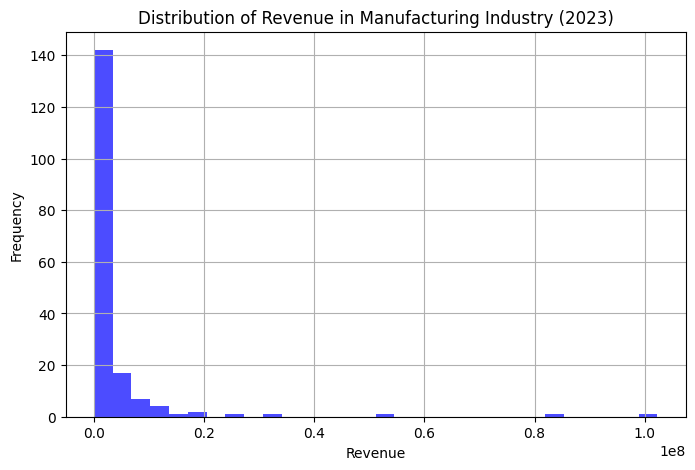

In [34]:
# Revenue
plt.figure(figsize=(8, 5))
plt.hist(man_ind['revenue'].dropna(), bins=30, color='blue', alpha=0.7)
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title('Distribution of Revenue in Manufacturing Industry (2023)')
plt.grid(True)
plt.show()

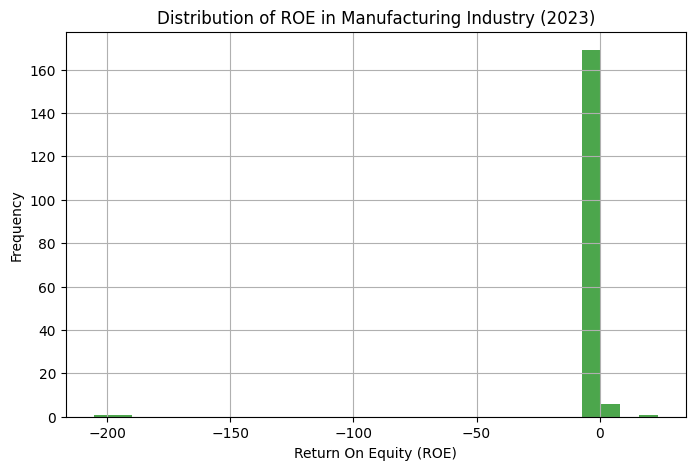

In [35]:
# ROE
plt.figure(figsize=(8, 5))
plt.hist(man_ind['ROE'].dropna(), bins=30, color='green', alpha=0.7)
plt.xlabel('Return On Equity (ROE)')
plt.ylabel('Frequency')
plt.title('Distribution of ROE in Manufacturing Industry (2023)')
plt.grid(True)
plt.show()

**REVENUE**

El ingreso promedio de la industria manufacturera en 2023 es de 4 millones aprox, sin embargo, tiene una desviación estándar muy alta, de aproximadamente 20 millones, lo que representa que existen algunas empresas que generan muchas ganancias y otras que generan muy pocas (existe demasiada variabilidad entre empresas de altas ganancias y de bajas). Podemos notar que como ingreso mínimo, hay un número en negativo, por lo que generó pérdidas en lugar de ganancias (y eso que son brutas, no netas) mientras que la empresa con una máxima ganancia fue de 383 millones aprox. La mediana de las empresas tienen ingresos menores a 338 mil dólares, lo cual es un número bastante menor a la media (tienen una diferencia de un poco más de 3 millones y medio, siendo la media la mayor), por ello, se sugiere usar a la mediana para representar a la mayoría de las empresas.

**ROE**

Mientras que, la ROE que nos dice la rentabilidad sobre el patrimonio muestra de igual manera una gran variabilidad, con tendencia a la baja o a los negativos, esto puede representar dificultades operativas en la industria.

#### 1.4.2 Matriz de correlación

Utilizando datos fiscales anuales (seleccionando filas con mes fiscal = 12) y todos los años:

Muestre una matriz de correlación con las mismas variables que utilizó para las estadísticas descriptivas anteriores, pero en el caso de activos totales, ingresos e ingresos netos, utilice la transformación logarítmica de sus valores. ¿Qué variables tienen una relación lineal más fuerte y significativa con los rendimientos de las acciones (rendimientos anuales)? Explicar

In [36]:
# Aplicar transformación logarítmica a 'totalassets', 'revenue', 'NETINCOME'
# Poner un caso para cuando se trate de calcular log de 0 (que es indefinido)
man_ind['log_totalassets'] = np.log(man_ind['totalassets'].replace(0, np.nan))
man_ind['log_revenue'] = np.log(man_ind['revenue'].replace(0, np.nan))
man_ind['log_NETINCOME'] = np.log(man_ind['NETINCOME'].replace(0, np.nan))

selected_features_log = ['return_y_future', 'log_totalassets', 'log_revenue', 'MARKETVALUE', 'BOOKVALUE', 'log_NETINCOME', 'ROE', 'NPM', 'ROIC', 'OPM']
correlation_data = man_ind[selected_features_log].corr()
print(correlation_data.round(2))

                 return_y_future  log_totalassets  log_revenue  MARKETVALUE  \
return_y_future             1.00             0.28         0.32         0.14   
log_totalassets             0.28             1.00         0.94         0.36   
log_revenue                 0.32             0.94         1.00         0.33   
MARKETVALUE                 0.14             0.36         0.33         1.00   
BOOKVALUE                   0.08             0.49         0.43         0.65   
log_NETINCOME               0.02             0.86         0.87         0.42   
ROE                        -0.00             0.12         0.13         0.02   
NPM                         0.08            -0.08         0.46        -0.01   
ROIC                        0.39             0.50         0.60         0.10   
OPM                         0.08            -0.08         0.47        -0.01   

                 BOOKVALUE  log_NETINCOME   ROE   NPM  ROIC   OPM  
return_y_future       0.08           0.02 -0.00  0.08  0.39  0

c:\Users\marif\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\marif\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Correlation Matriz')

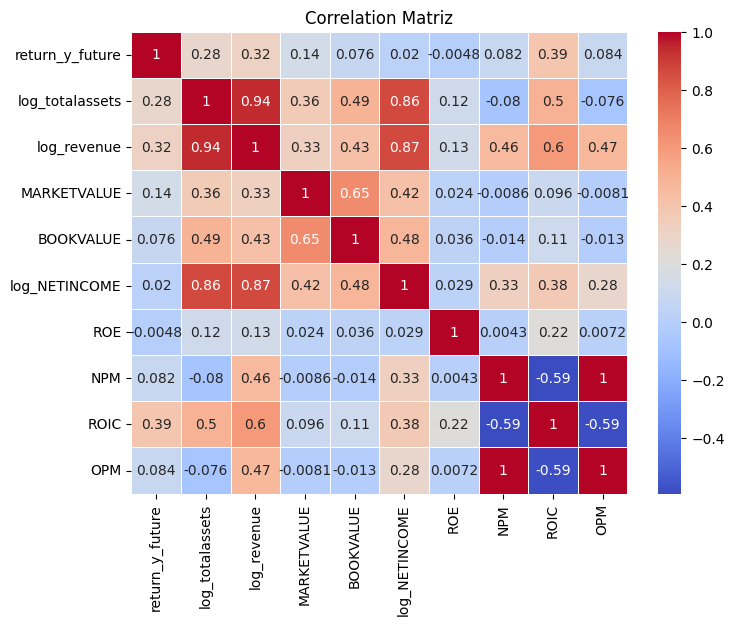

In [37]:
import seaborn as sns

# Crear la matriz de correlación con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matriz')


Enu na matriz de correlación, mientras más cercano sea la correlación cercana a 1, tiene una relación más fuerte con los retornos de y. Teniendo esto en mente, la relación más fuerte de una variable con los retornos de y es el finantial ratio ROIC (Retorno sobre el Capital Invertido), por lo que podemos pensar que las empresas que son más eficientes en generar retornos sobre el caítal invertido suelen tener mayores rendimientos en el mercado de acciones.

De igual manera, el logaritmo de totalassets muestra una correlación alta, pues es de 0.37 con respecto a el retorno de y, lo que puede significar que las empresas con mayores activos suelen tener mejores rendimientos en sus acciones (más activos = más ingresos).

Las relaciones que no se muestran tan fuertes son las de 'ROE', 'OPM' y 'NPM', pues estas son cercanas a 0 (es decir que no existe relación ni positiva ni negativa).



#### 1.4.3 Modelo de regresión
Para cada ratio financiero, haga lo siguiente:
Hacer un histograma e interpretarlo.

Haga gráficos para visualizar la posible relación que podría tener cada factor con los rendimientos trimestrales (la variable dependiente).

Diseñe y ejecute una primera versión de un modelo de regresión múltiple para examinar si los índices seleccionados pueden explicar/predecir futuros rendimientos anuales de las acciones.

Debe comprobar posibles problemas de multicolinealidad. Explicar brevemente qué es la multicolinealidad, ejecutar e interpretar la prueba correspondiente.

Interpreta tu modelo

Interpreta con tus propias palabras los resultados de cada coeficiente (beta y su significancia estadística)

Interpretar el R cuadrado del modelo.

Escribe una conclusión de tus resultados.



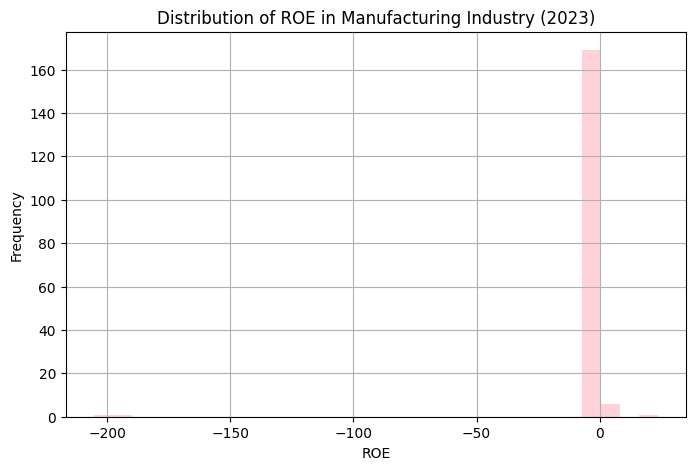

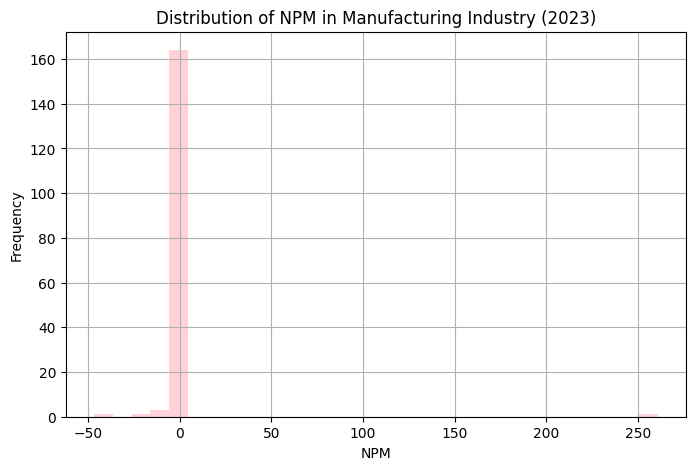

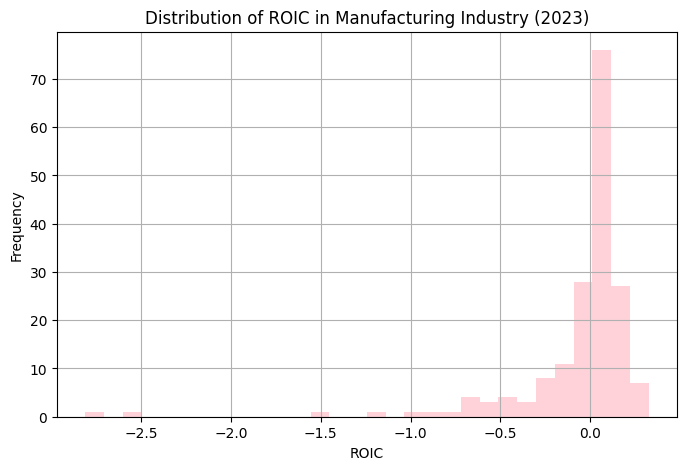

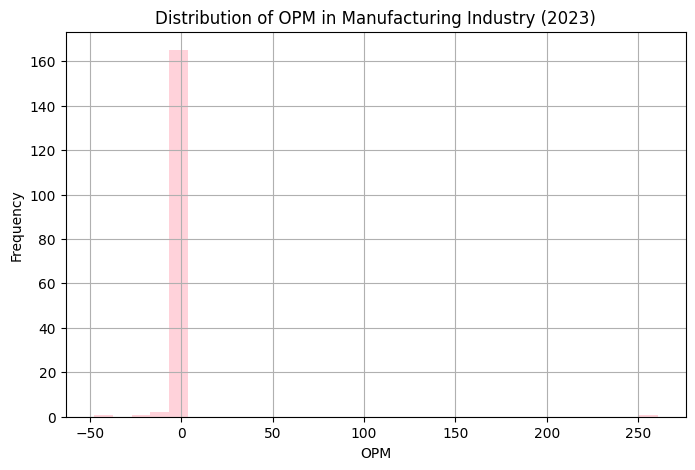

In [38]:
finantial_ratios = ['ROE', 'NPM', 'ROIC', 'OPM']

for ratio in finantial_ratios: # Changed the loop variable to 'ratio' for clarity
  plt.figure(figsize=(8, 5))
  # Reemplazar valores infinitos con nan
  valid_data = man_ind[ratio].dropna().replace([np.inf, -np.inf], np.nan).dropna()
  plt.hist(valid_data, bins=30, color='pink', alpha=0.7)
  plt.xlabel(ratio)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {ratio} in Manufacturing Industry (2023)')
  plt.grid(True)
  plt.show()

**Return on Equity**

La distribución de este histograma muestra que la empresa tiene un ROE cercano a 0, teniendo casi todos los valores en este número o cercano a este. Además, existen empresas con valores negativos para ROE (hasta en -200) y positivos hasta 100, por lo que muchas de las empresas tienen bajos retornos sobre su patrimonio, lo que puede significar dificultades para generar ganancias por accionistas (incluso llegando a tener pérdidas teniendo el ROE negativo).

**Net Profit Margin (NPM)**

Su histograma muestra que de igual manera, muchas de las empresas presentan un NPM bajo, incluso negativo,llegando hasta -3500%. Se puede ver un significante sesgo hacia la izquierda (negativos), pues muchas de las empresas al parecer están laborando con pérdidas.

**Return on Invested Capital (ROIC)**

Su distribución de igual manera se encuentra concentrada en valores negativos y en 0 (que es donde mayormente se encuentra). Muchas de las empresas se encuentran entre 0 y -2 pero tiene valores de hasta -10. El tener el ROIC bajo quiere decir que las empresas no están generando suficientes ganancias en relación con el capital invertido, por lo que muestra que no se está usando eficientemente el capital.

**Operating Profit Margin (OPM)**

Muestra una distribución bastante parecida a NPM (muchos de sus valores en negativos y muy pocos en positivos). Tener OPM negativo quiere decir que las operaciones básicas de las empresas no son rentables, por lo que puede tener un alto costo operativo y baja demanda de servicios o productos de la empresa.


En general, las empresas pelean por tener retornos positivos con sus operaciones, capital y capital invertido, por lo que puede indicar una época económica difícil.

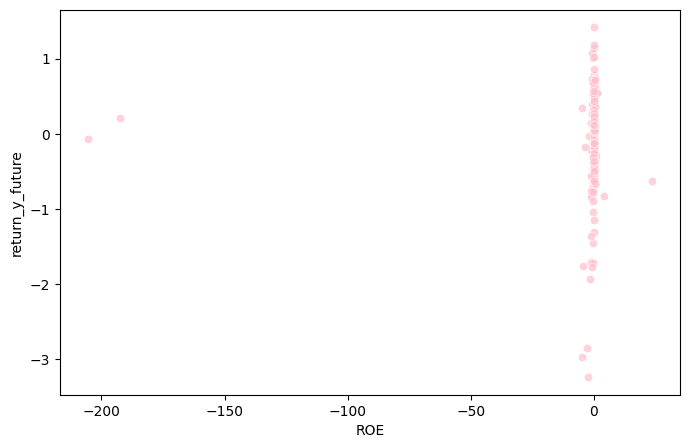

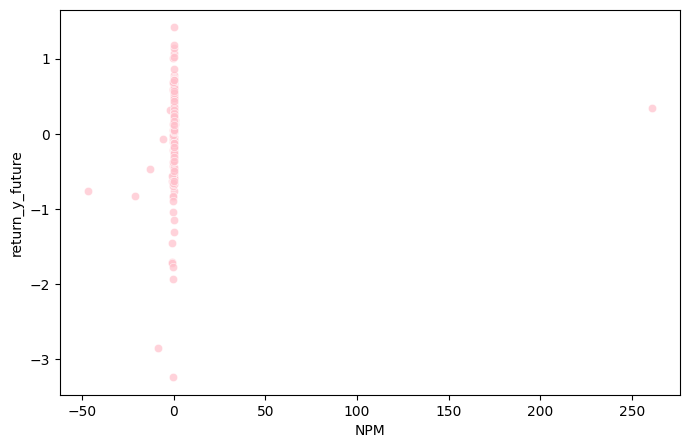

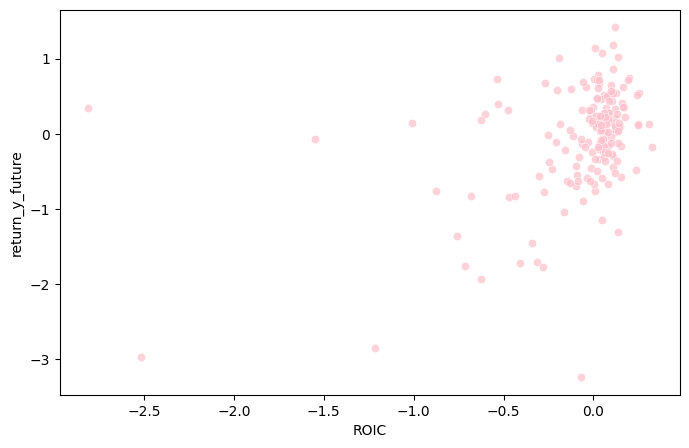

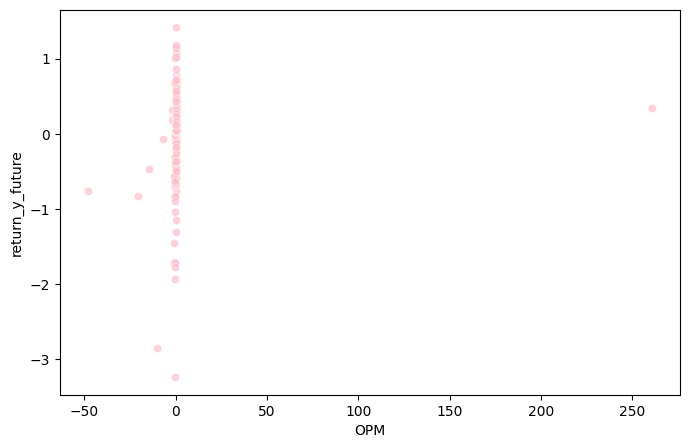

In [39]:
# Gráficas de relación: Ratios financiertos con rendimiento trimestral
for ratio in finantial_ratios:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=ratio, y='return_y_future', data=man_ind, color='pink', alpha=0.7)
    plt.xlabel(ratio)
    plt.ylabel
    plt.show()


In [40]:
# Modelo de regresión múltiple
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Definir los finantial ratios como la variable independiente
man_ind_clean = man_ind[finantial_ratios + ['return_y_future']].replace([np.inf, -np.inf], np.nan).dropna()

X = man_ind_clean[finantial_ratios]
# Definir los retornos de y como la variable dependiente
y = man_ind_clean['return_y_future']

# Agregar una constante al modelo
X = sm.add_constant(X)

# Ajustar el modelo de regresión múltiple
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        return_y_future   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     11.29
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           4.00e-08
Time:                        16:39:26   Log-Likelihood:                -146.92
No. Observations:                 170   AIC:                             303.8
Df Residuals:                     165   BIC:                             319.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0138      0.045     -0.307      0.7

In [41]:
# Comprobar multicolienalidad

vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

  Feature          VIF
0   const     1.016065
1     ROE     1.122397
2     NPM  6371.427341
3    ROIC     2.388387
4     OPM  6294.712088


**Multicolienalidad**

Es cuando dos o más variables independientes en el modelo de regresión son muy correlacionadas, es decir, que presentan una alta correlación alta entre ellas aparte de la variable independiente. La multicolienalidad es un problema pues si es alta, los errores estándar de los coeficientes pueden ser altos, lo que lleva que los p-values sean altos y por ende, que no tengan relevancia en el modelo.

**Prueba VIF**

El Variance Inflation Factor (VIF) mide la varianza de un coeficiente estimado cuando se incrementa por la multicolienalidad, si un VIF es mayor a 10, hay problemas de multicolinealidad. Podemos ver que NPM y OPM tienen valores mayores a 10, por lo que están altamente relacionadas, afectando la precisión del modelo.

**R^2**

La R cuadrada mide el qué tan bien se ajustan los datos en una regresión. El haber obtenido 0.281 indica que el 28.1% de los retornos de y pueden explicarse con los ratios del modelo, lo caul, es muy bajo, pues existe un 71.9% que el modelo no sea bien explicado.

**Coeficientes beta**

- Roe: Da un coeficiente de -0.0019, por lo que no tiene un valor estadístico sifnificativo (p-value > 0.05), no tiene relación con los retornos de y.
- NPM: 14.385049 (p-value < 0.05), esto indica que el NPM está muy relacionado con los retornos de y.
- ROIC: 1.016227 (p-value < 0.05), es positivo y significativo, por lo que ROIC es mejor para predecir el modelo.
